## Predicting User Knowledge Levels 

Group 40 Members: Sam Kao, Namya Sharma, Lucy Duan, Jason Zhou

### Introduction:

A person’s level of knowledge cannot be evaluated unilaterally, and different people with different knowledge levels could be better assigned an appropriate job in a firm or in a research group, so that they will do their own work efficiently. The User Knowledge datasat covers six variables: STG (The degree of study time for goal object materials), SCG (The degree of repetition number of user for goal object materials), STR (The degree of study time of user for related objects with goal object), LPR (The exam performance of user for related objects with goal object), PEG (The exam performance of user for goal objects), and UNS (an individual’s knowledge level). There are a total of 403 observations and the first five variables are all numerical doubles, whereas UNS is a categorical variable. 
As the time passes, the global job market becomes more competitive than before. Thousands of people with differing strengths compete for the same job; therefore, we need a model to select applicants most efficiently. Such a model can alleviate stress from a corporation's recruitment team.

Question: What will the knowledge level (UNS) of a user be (very low, low, middle or high) based on their length of study of the goal objects (STG), and their exam performance of goal object (PEG)?

### Preliminary exploratory data analysis:

In [2]:
library(tidyverse)
library(readxl)
library(dplyr)
library(gridExtra)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [3]:
# reading the data
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
download.file(url, "data.xls")
training_data <- read_excel("data.xls", sheet = 2) # sheet 2 => training data

# select only the columns we need and making our class as a factor
training_data <- training_data %>%
    select(1:6) %>%
    mutate(UNS = as_factor(UNS))

training_data

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


In [4]:
# summarize the training data, counting how many occurences of each class 
num_of_class <- training_data %>%
    mutate(UNS = factor(UNS, levels = c("High", "Middle", "Low", "very_low"))) %>%
    count(UNS)

num_of_class

UNS,n
<fct>,<int>
High,63
Middle,88
Low,83
very_low,24


In [5]:
#the means of the predictor variables you plan to use in your analysis
predictors_mean <- training_data %>%
                  summarize (mean_STG = mean(STG, na.rm = TRUE),
                             mean_PEG = mean(PEG, na.rm = TRUE))
predictors_mean

mean_STG,mean_PEG
<dbl>,<dbl>
0.3711473,0.4585388


In [6]:
#how many rows have missing data
missing_data <- training_data %>% 
        filter(is.na(STG), is.na(PEG), is.na(SCG), is.na(STR), is.na(LPR), is.na(UNS))
missing_data_count <- nrow(missing_data)
missing_data_count

[1] 0

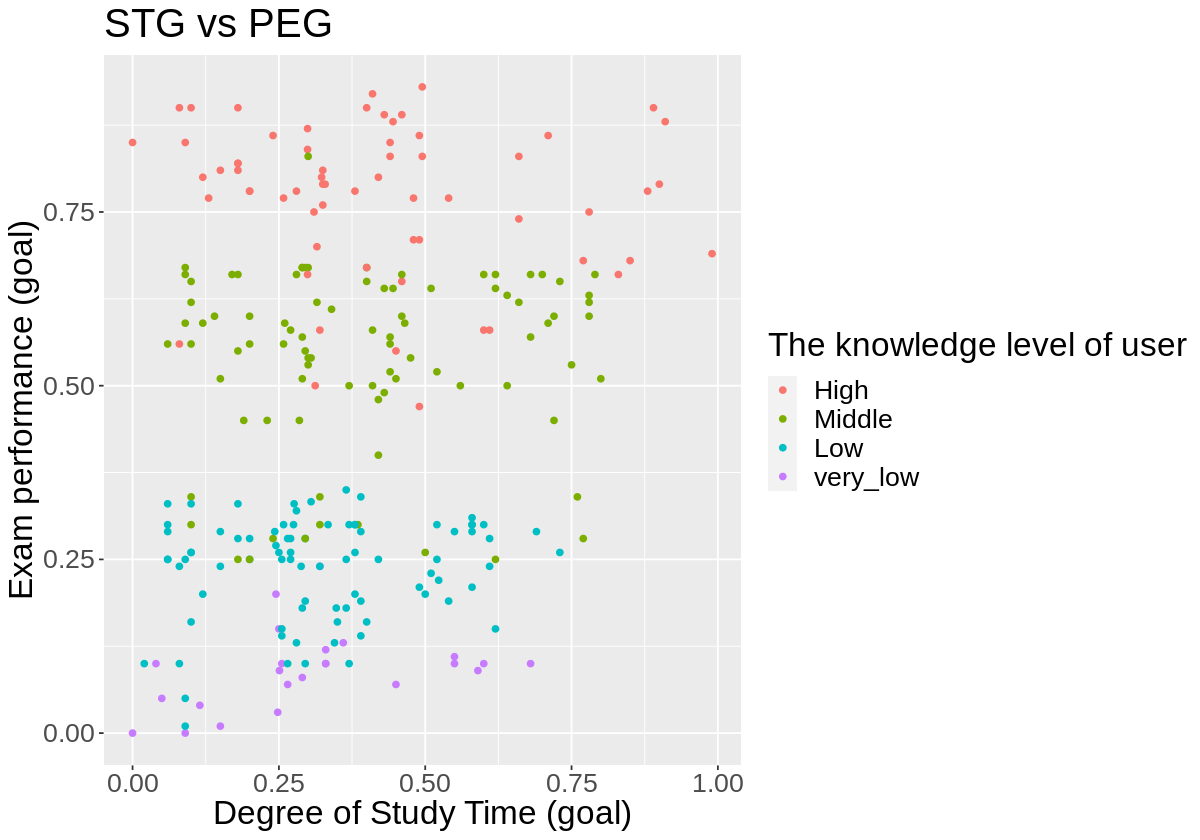

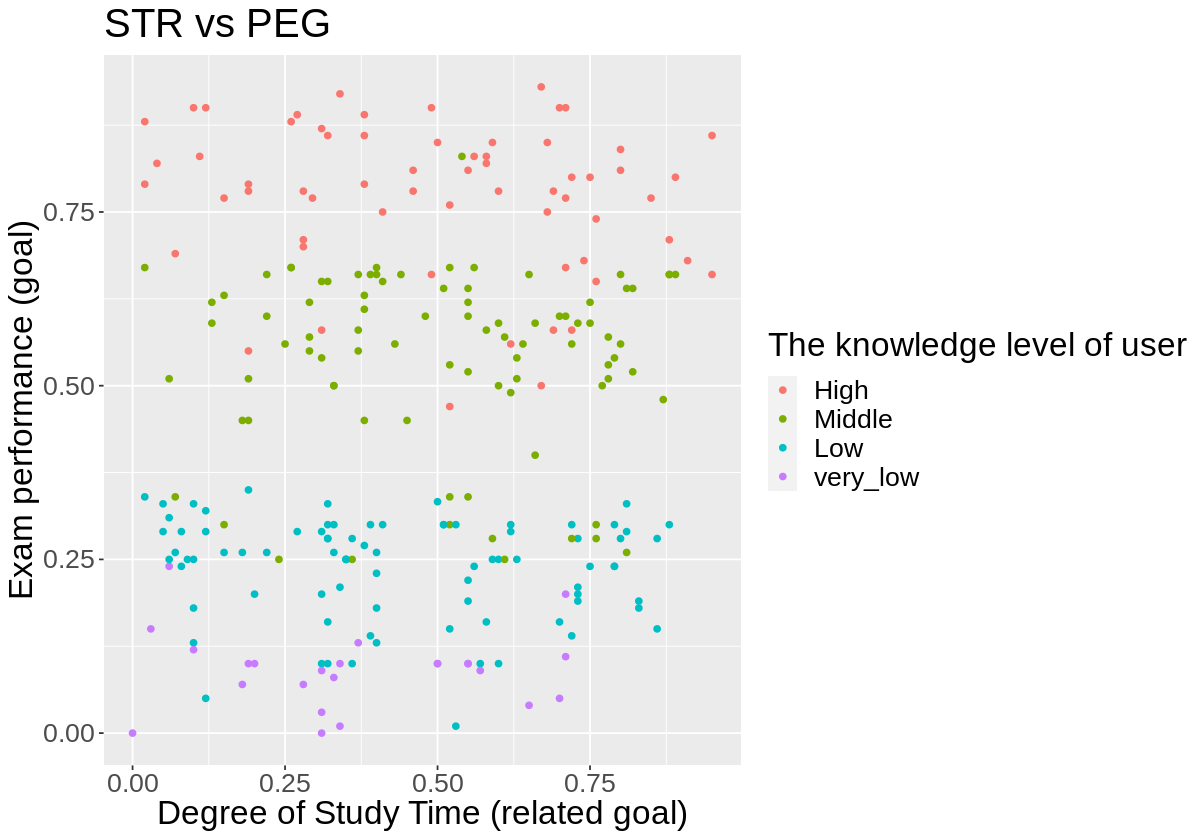

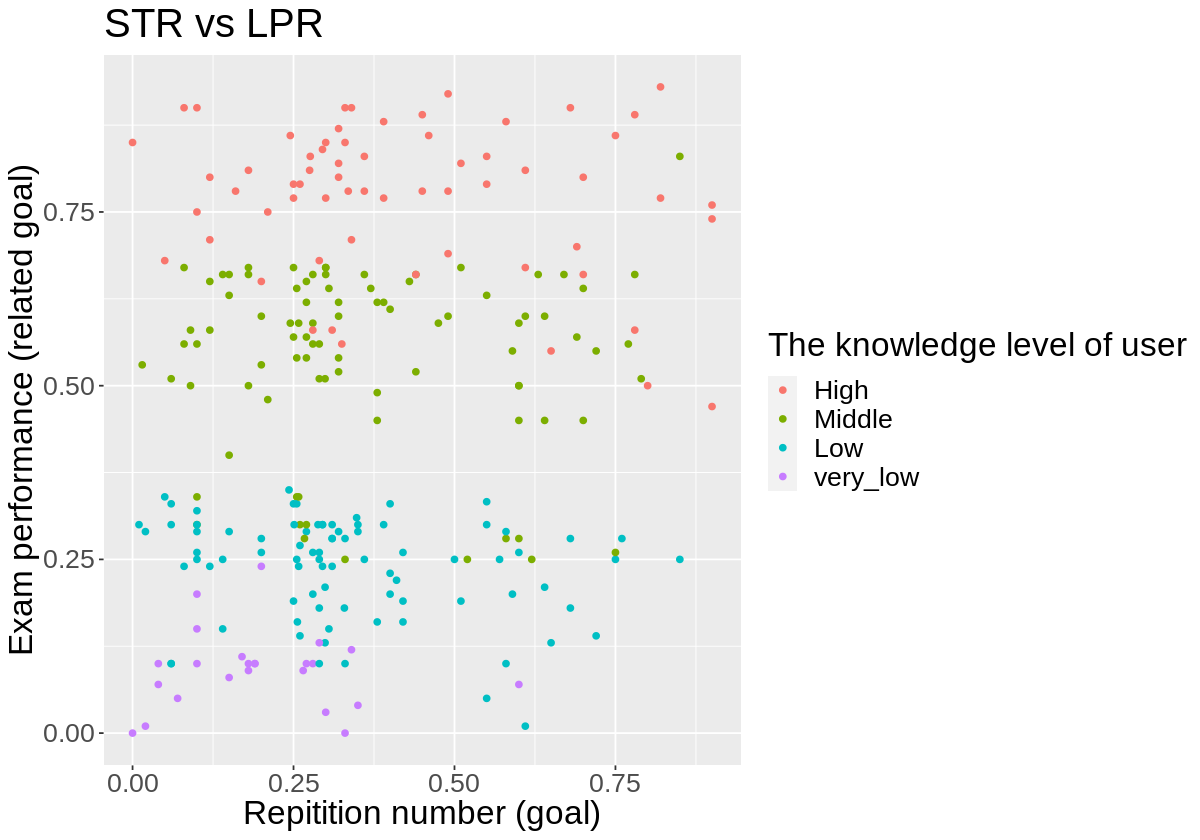

In [39]:
# plot STG vs PEG and coloring the class of UNS
# STG => The degree of study time for goal object materails
# PEG => The exam performance of user for goal objects
options(repr.plot.width = 10, repr.plot.height = 7) 
plot1 <- training_data %>%
    mutate(UNS = factor(UNS, levels = c("High", "Middle", "Low", "very_low"))) %>%
    ggplot(aes(x = STG, y = PEG, color = UNS)) +
    geom_point() +
    labs(x = "Degree of Study Time (goal)", y="Exam performance (goal)", color= "The knowledge level of user")+
    ggtitle('STG vs PEG')+
    theme(text = element_text(size=20))

plot2 <- training_data %>%
    mutate(UNS = factor(UNS, levels = c("High", "Middle", "Low", "very_low"))) %>%
    ggplot(aes(x = STR, y = PEG, color = UNS)) +
    geom_point() +
    labs(x = "Degree of Study Time (related goal)", y="Exam performance (goal)", color= "The knowledge level of user")+
    ggtitle('STR vs PEG')+
    theme(text = element_text(size=20))

plot3 <- training_data %>%
    mutate(UNS = factor(UNS, levels = c("High", "Middle", "Low", "very_low"))) %>%
    ggplot(aes(x = SCG, y = PEG, color = UNS)) +
    geom_point() +
    labs(x = "Repitition number (goal)", y="Exam performance (related goal)", color= "The knowledge level of user")+
    ggtitle('STR vs LPR')+
    theme(text = element_text(size=20))

plot1
plot2
plot3

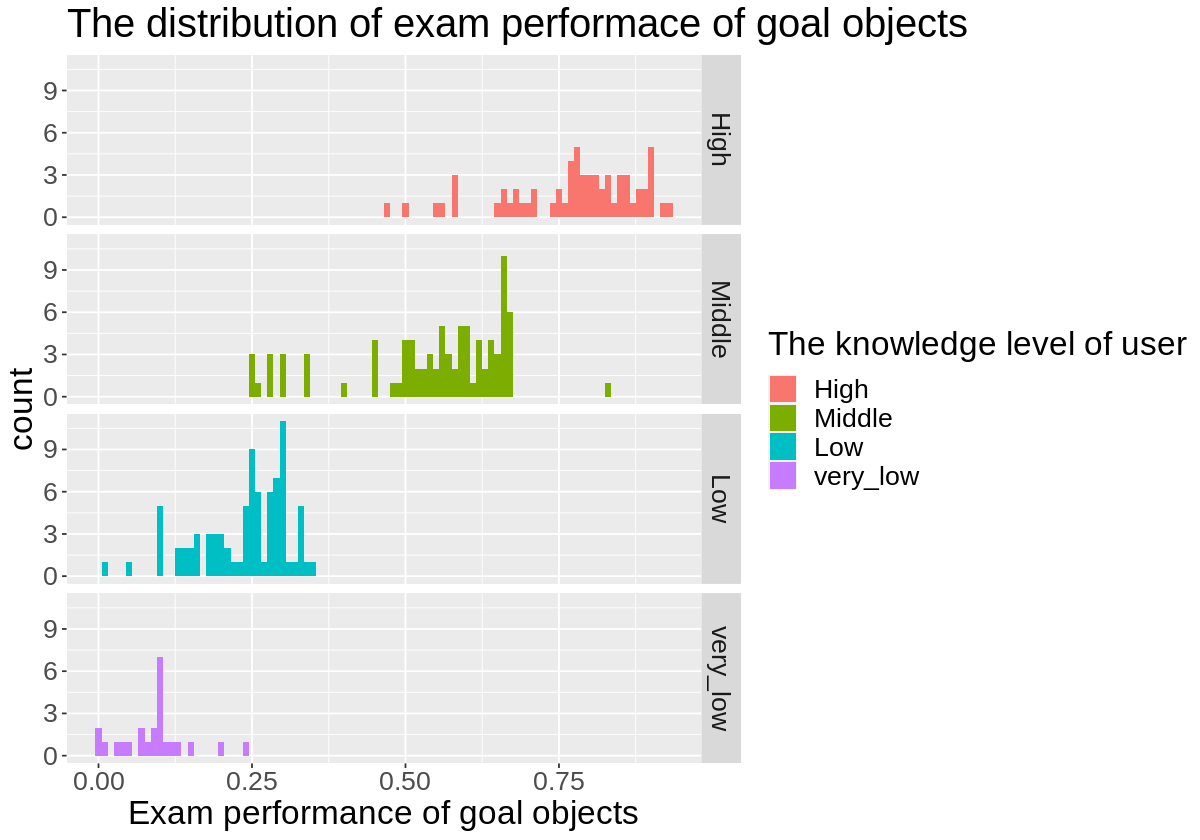

In [8]:
#compare the distributions of each of the predictor variables you plan to use in your analysis
#the distribution of exam performace of goal objects

options(repr.plot.width = 10, repr.plot.height = 7) 
distr_PEG <- training_data %>%
    mutate(UNS = factor(UNS, levels = c("High", "Middle", "Low", "very_low"))) %>% 
    ggplot(aes(x = PEG, fill = UNS)) +
    geom_histogram(binwidth = .01)+
    labs(x = "Exam performance of goal objects", fill = "The knowledge level of user")+
    ggtitle("The distribution of exam performace of goal objects")+
    theme(text = element_text(size=20))+
    facet_grid(rows = vars(UNS))

distr_PEG

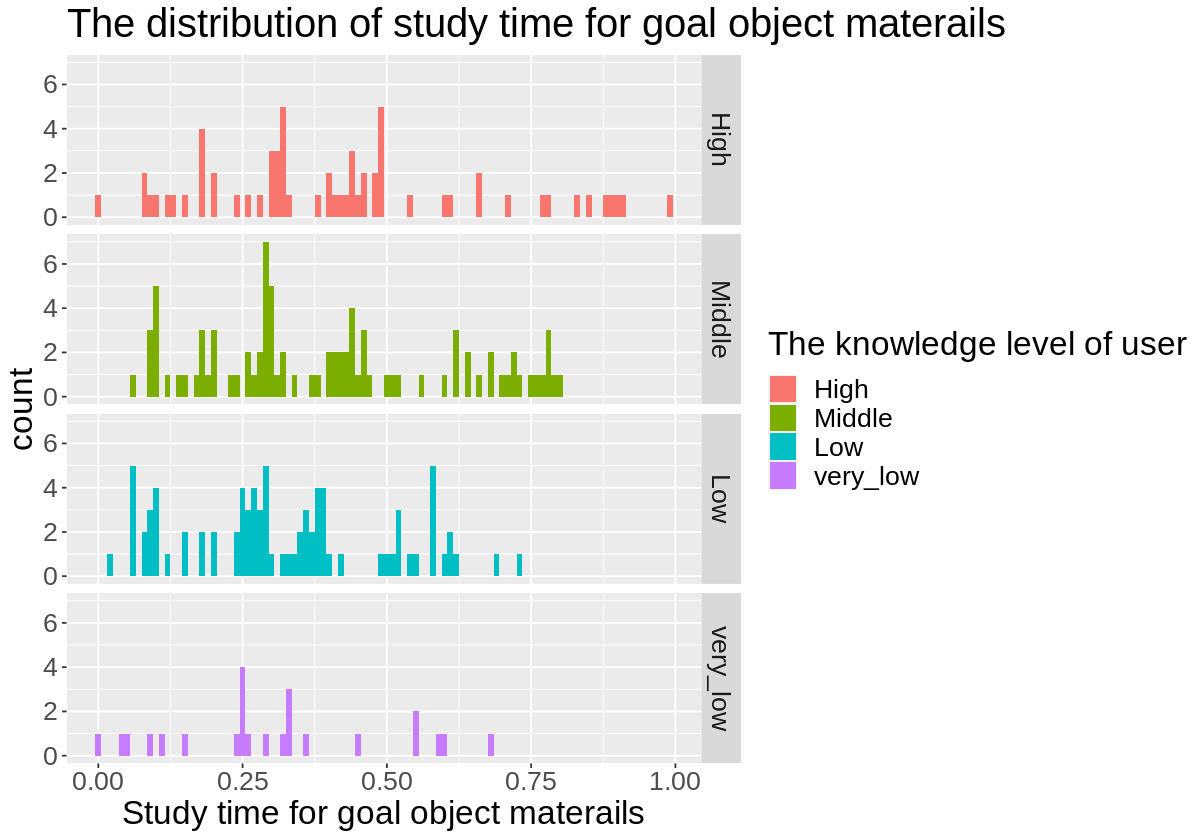

In [8]:
#compare the distributions of each of the predictor variables you plan to use in your analysis
#The distribution of the degree of study time for goal object materails (STG)
options(repr.plot.width = 10, repr.plot.height = 7) 
distr_STG <- training_data %>%
    mutate(UNS = factor(UNS, levels = c("High", "Middle", "Low", "very_low"))) %>%
    ggplot(aes(x = STG, fill = UNS)) +
    geom_histogram(binwidth = .01)+
    labs(x = "Study time for goal object materails", fill = "The knowledge level of user")+
    ggtitle("The distribution of study time for goal object materails")+
    theme(text = element_text(size= 20))+
    facet_grid(rows = vars(UNS))

distr_STG


Warning message:
“package ‘cowplot’ was built under R version 4.0.3”


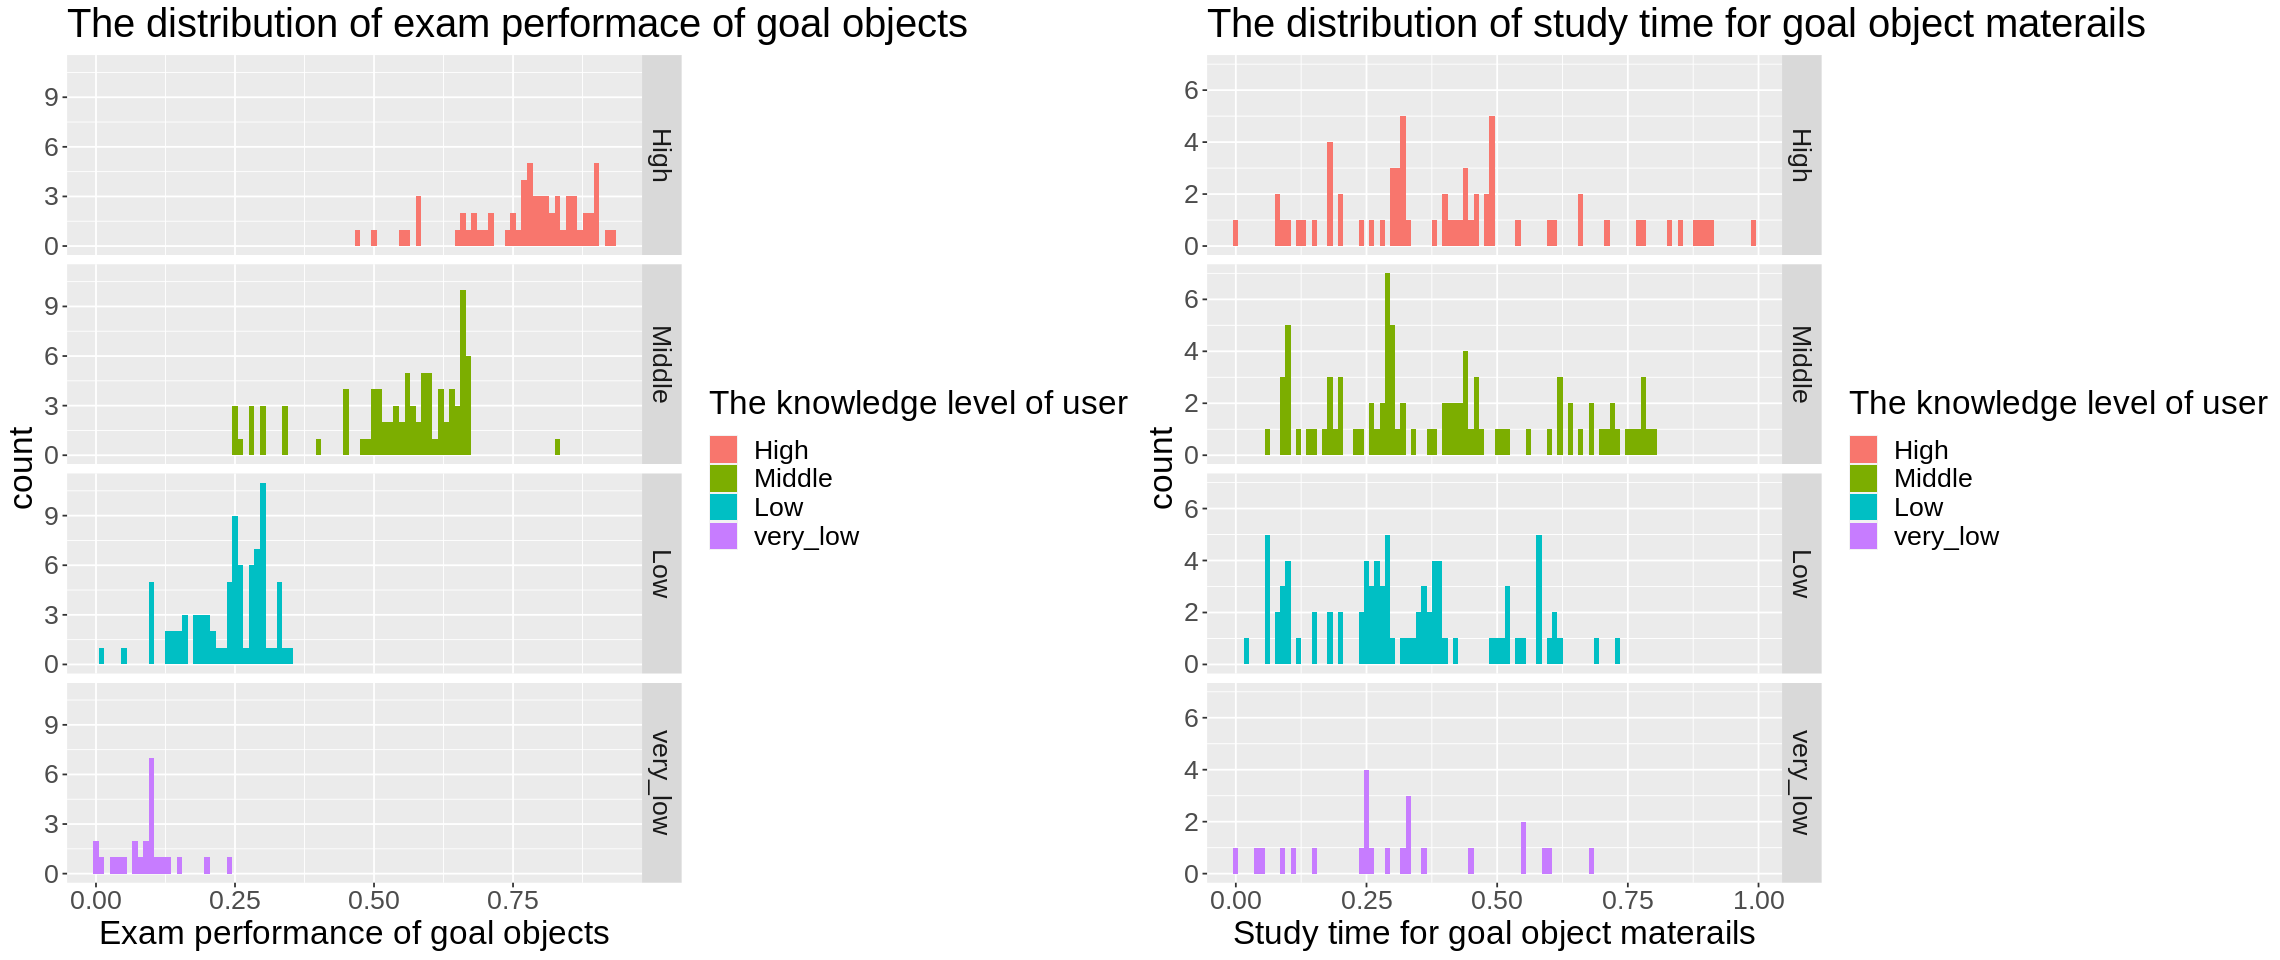

In [9]:
#compare the distributions of each of the predictor variables you plan to use in your analysis
library(cowplot)
options(repr.plot.width = 19, repr.plot.height = 8)
plot_grid(distr_PEG, distr_STG)
options(repr.plot.width = 19, repr.plot.height = 8)

### Methods:

We will use STG (The degree of study time for goal object materials) and PEG (The exam performance of users for goal objects) to find the relationships with UNS (an individual’s knowledge level). We decided to use these variables since we believe time spent studying for the goal object and its respective exam performance are the best predictors for an individual’s knowledge level. When PEG was plotted against STG, STR, and SCG, we saw similar correlation; Thus, the more influential variable must be PEG. Due to this, it is more logical to use STG alongside PEG since they both relate to an individual's "goal" object instead of "related" goal.  We will select STG and PEG for our k-nearest neighbour UNS prediction. We will also tune our model to select the best ‘k’ value for our model by performing cross validation before applying our fitted model to our testing dataset, from which we can determine the accuracy of it.


### Expected outcomes and significance:

We expect STG and PEG to be the two best predictors to classify the UNS of a new individual, and thus produce a model with relatively good accuracy in relation to the context and application of our model. After preliminary analysis, we expect PEG to play a larger role than STG in UNS prediction since graphically, those with higher PEG values tend to be classified as “high” in terms of UNS. These findings can allow us to  predict an individual’s knowledge level based on degree of study time and exam performance in the real world.  A prediction of the reversal could also be made. In the future, it would be interesting to also investigate the impact of other variables such as STR and LPR on classifying knowledge level.